In [1]:
%matplotlib inline 

import tensorflow as tf 
import pickle as pkl
import matplotlib.pyplot as plt  
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
def getInputs(gen_dim, dis_dim):
    x = tf.placeholder(tf.float32,(None,gen_dim), name='z_input')
    y = tf.placeholder(tf.float32,(None,dis_dim), name='real_input')
    return x,y

In [3]:
###Generator 
## will use leaky relu 
def generator(z,out_dim, n_units = 128, alpha = 0.01, reuse=False): 
    
    with tf.variable_scope('generator', reuse=reuse):
        
        h1 = tf.layers.dense(z,n_units,activation=None)
        h1 = tf.maximum(alpha*h1,h1)

        logits = tf.layers.dense(h1,out_dim, activation=None)
        out = tf.tanh(logits)  ### generator has been found to work best with tanh function


        return out, logits

In [4]:
##Discriminator
def discriminator(input_data,n_units=128, alpha = 0.01, reuse=False):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        h1 = tf.layers.dense(input_data,n_units,activation=None)
        h1 = tf.maximum(alpha*h1,h1)
        
        logits = tf.layers.dense(h1,1,activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [5]:
####hyperparameters 
input_data_dim = 28*28
gen_input_dim = 200

##hidden_layer dimensions
g_hidden_dim = 128 
d_hidden_dim = 128

###
alpha = 0.01
smooth = 0.1


In [6]:
###Built the graph 
tf.reset_default_graph() 

z_input, input_data = getInputs(gen_input_dim,input_data_dim) 

g_model, g_logits = generator(z_input,input_data_dim)

d_model_real, d_logits_real = discriminator(input_data)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)


In [7]:
print(g_model)

Tensor("generator/Tanh:0", shape=(?, 784), dtype=float32)


In [8]:
## Define the loss function 
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, 
                                                                  labels=tf.ones_like(d_logits_fake)))

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)*(1-smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))

d_loss = d_loss_real + d_loss_fake 

In [9]:
## Define the optimizers 
learning_rate = 0.001
tvars = tf.trainable_variables()
g_vars = [var for var in tvars if var.name.startswith('generator')]
d_vars = [var for var in tvars if var.name.startswith('discriminator')]
print(tvars)
print(g_vars)
print(d_vars)
g_train_op = tf.train.AdamOptimizer(learning_rate).minimize(gen_loss, var_list = g_vars)
d_train_op = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list = d_vars)

[<tf.Variable 'generator/dense/kernel:0' shape=(200, 128) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>, <tf.Variable 'discriminator/dense/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'discriminator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'generator/dense/kernel:0' shape=(200, 128) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'discriminator/dense/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.

In [10]:
mnist.train.num_examples

55000

In [11]:
import numpy as np

In [12]:
###Training code 
n_epochs = 500
batch_size = 100
samples = [] 
losses = [] 

saver = tf.train.Saver(var_list=g_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(n_epochs):
        
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            ##Reshape and rescale to pass into D 
            batch_images = batch[0].reshape((batch_size,784))
            batch_images = batch_images*2 -1 
            
            ## Sample random vector fog latent variable 
            batch_z = np.random.uniform(-1,1,size=(batch_size,gen_input_dim))
            
            _ = sess.run(d_train_op,feed_dict={input_data:batch_images,z_input:batch_z})
            _ = sess.run(g_train_op, feed_dict={z_input:batch_z})
            
            
        train_loss_d = sess.run(d_loss,feed_dict={input_data:batch_images,z_input:batch_z})
        train_loss_g = sess.run(gen_loss,feed_dict={input_data:batch_images,z_input:batch_z})
        
        print("Epoch {}/{}...".format(e+1, n_epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
        losses.append((train_loss_d,train_loss_g))
        
        ###Sample mide training to see the evolution 
        z_sample= np.random.uniform(-1,1,size=(16,gen_input_dim))
        gen_samples, _ = sess.run(generator(z_input, input_data_dim,reuse=True),feed_dict={z_input:z_sample})
        samples.append(gen_samples)
        saver.save(sess,'./checkpoints/generator.ckpt')
        


        

Epoch 1/500... Discriminator Loss: 0.3608... Generator Loss: 3.7784
Epoch 2/500... Discriminator Loss: 0.4493... Generator Loss: 2.7091
Epoch 3/500... Discriminator Loss: 0.7315... Generator Loss: 3.8117
Epoch 4/500... Discriminator Loss: 0.7409... Generator Loss: 2.8404
Epoch 5/500... Discriminator Loss: 1.0164... Generator Loss: 2.9992
Epoch 6/500... Discriminator Loss: 0.7669... Generator Loss: 2.5171
Epoch 7/500... Discriminator Loss: 1.0150... Generator Loss: 2.7662
Epoch 8/500... Discriminator Loss: 0.5410... Generator Loss: 4.0625
Epoch 9/500... Discriminator Loss: 1.1535... Generator Loss: 1.4729
Epoch 10/500... Discriminator Loss: 0.9152... Generator Loss: 2.7531
Epoch 11/500... Discriminator Loss: 1.1228... Generator Loss: 1.9059
Epoch 12/500... Discriminator Loss: 0.7779... Generator Loss: 2.2999
Epoch 13/500... Discriminator Loss: 1.2771... Generator Loss: 2.8572
Epoch 14/500... Discriminator Loss: 1.1868... Generator Loss: 2.2438
Epoch 15/500... Discriminator Loss: 2.1817.

Epoch 120/500... Discriminator Loss: 1.0009... Generator Loss: 1.7843
Epoch 121/500... Discriminator Loss: 0.9048... Generator Loss: 1.8558
Epoch 122/500... Discriminator Loss: 0.9881... Generator Loss: 1.4797
Epoch 123/500... Discriminator Loss: 0.8949... Generator Loss: 2.0027
Epoch 124/500... Discriminator Loss: 0.9200... Generator Loss: 1.5071
Epoch 125/500... Discriminator Loss: 0.9598... Generator Loss: 1.5585
Epoch 126/500... Discriminator Loss: 1.0505... Generator Loss: 1.7449
Epoch 127/500... Discriminator Loss: 1.0058... Generator Loss: 1.4544
Epoch 128/500... Discriminator Loss: 1.1678... Generator Loss: 1.6297
Epoch 129/500... Discriminator Loss: 0.9049... Generator Loss: 1.6254
Epoch 130/500... Discriminator Loss: 1.0823... Generator Loss: 1.4225
Epoch 131/500... Discriminator Loss: 0.9360... Generator Loss: 1.6630
Epoch 132/500... Discriminator Loss: 0.9102... Generator Loss: 1.7709
Epoch 133/500... Discriminator Loss: 0.8805... Generator Loss: 1.8599
Epoch 134/500... Dis

Epoch 238/500... Discriminator Loss: 0.9278... Generator Loss: 1.6921
Epoch 239/500... Discriminator Loss: 0.9939... Generator Loss: 1.5442
Epoch 240/500... Discriminator Loss: 0.9860... Generator Loss: 1.8854
Epoch 241/500... Discriminator Loss: 1.0030... Generator Loss: 1.6846
Epoch 242/500... Discriminator Loss: 1.0909... Generator Loss: 1.5902
Epoch 243/500... Discriminator Loss: 1.1212... Generator Loss: 1.9534
Epoch 244/500... Discriminator Loss: 0.8852... Generator Loss: 1.7873
Epoch 245/500... Discriminator Loss: 0.9760... Generator Loss: 1.8826
Epoch 246/500... Discriminator Loss: 0.9225... Generator Loss: 1.9828
Epoch 247/500... Discriminator Loss: 0.9864... Generator Loss: 1.9231
Epoch 248/500... Discriminator Loss: 1.0657... Generator Loss: 1.5824
Epoch 249/500... Discriminator Loss: 0.9663... Generator Loss: 1.8104
Epoch 250/500... Discriminator Loss: 1.0092... Generator Loss: 1.8938
Epoch 251/500... Discriminator Loss: 0.9900... Generator Loss: 1.6820
Epoch 252/500... Dis

Epoch 356/500... Discriminator Loss: 0.8974... Generator Loss: 2.0530
Epoch 357/500... Discriminator Loss: 0.9987... Generator Loss: 2.1356
Epoch 358/500... Discriminator Loss: 0.8546... Generator Loss: 2.1375
Epoch 359/500... Discriminator Loss: 0.8846... Generator Loss: 1.7425
Epoch 360/500... Discriminator Loss: 0.9368... Generator Loss: 2.2238
Epoch 361/500... Discriminator Loss: 0.9867... Generator Loss: 1.8580
Epoch 362/500... Discriminator Loss: 0.9843... Generator Loss: 1.5814
Epoch 363/500... Discriminator Loss: 0.9329... Generator Loss: 1.6012
Epoch 364/500... Discriminator Loss: 1.0124... Generator Loss: 1.8190
Epoch 365/500... Discriminator Loss: 0.9204... Generator Loss: 1.9468
Epoch 366/500... Discriminator Loss: 0.8947... Generator Loss: 1.7730
Epoch 367/500... Discriminator Loss: 0.8921... Generator Loss: 1.8592
Epoch 368/500... Discriminator Loss: 0.9794... Generator Loss: 2.0989
Epoch 369/500... Discriminator Loss: 0.9151... Generator Loss: 1.8945
Epoch 370/500... Dis

Epoch 474/500... Discriminator Loss: 1.0193... Generator Loss: 2.4802
Epoch 475/500... Discriminator Loss: 0.9779... Generator Loss: 1.9893
Epoch 476/500... Discriminator Loss: 0.8888... Generator Loss: 1.7886
Epoch 477/500... Discriminator Loss: 0.8650... Generator Loss: 1.8454
Epoch 478/500... Discriminator Loss: 0.9184... Generator Loss: 1.8706
Epoch 479/500... Discriminator Loss: 0.8877... Generator Loss: 1.9375
Epoch 480/500... Discriminator Loss: 0.8834... Generator Loss: 2.3172
Epoch 481/500... Discriminator Loss: 0.8859... Generator Loss: 1.9899
Epoch 482/500... Discriminator Loss: 0.9090... Generator Loss: 1.9586
Epoch 483/500... Discriminator Loss: 0.8685... Generator Loss: 2.0004
Epoch 484/500... Discriminator Loss: 0.9673... Generator Loss: 2.0401
Epoch 485/500... Discriminator Loss: 0.8712... Generator Loss: 2.3172
Epoch 486/500... Discriminator Loss: 0.8409... Generator Loss: 1.7871
Epoch 487/500... Discriminator Loss: 0.9111... Generator Loss: 2.1509
Epoch 488/500... Dis

In [13]:
with open('train_samples.pkl','wb') as f:
    pkl.dump(samples,f)

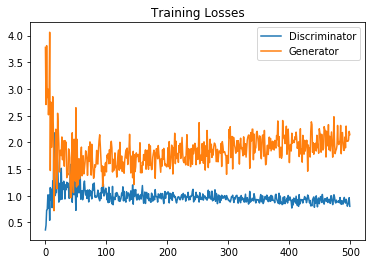

In [14]:
##visualize the loss  curves 
fig, axes = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0],label = ('Discriminator'))
plt.plot(losses.T[1], label = ('Generator'))
plt.title("Training Losses")
plt.legend()

In [15]:
### Generating code
###Generate Images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [16]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

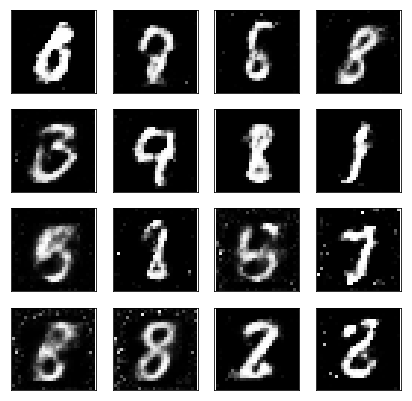

In [18]:
_ = view_samples(-1,samples)

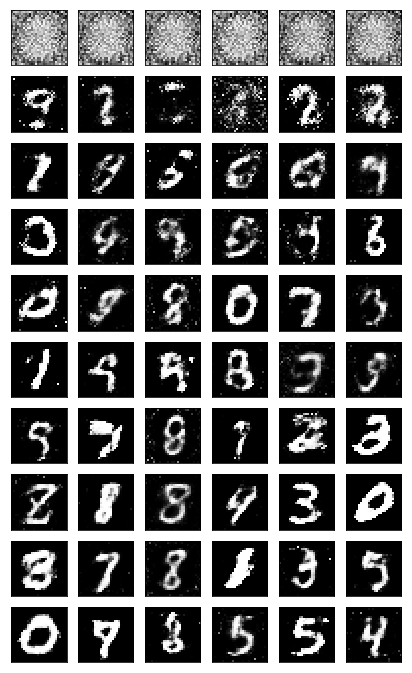

In [20]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


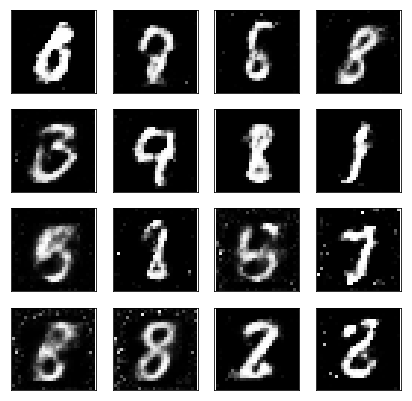

In [19]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, gen_input_dim))
    gen_samples,x = sess.run(
                   generator(z_input, input_data_dim, reuse=True),
                   feed_dict={z_input: z_sample})
_ = view_samples(0, [gen_samples])